In [110]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Alex Mallen (atmallen@uw.edu)
"""

import numpy as np
import matplotlib.pyplot as plt
import torch
import random

from dpk import model_objs

seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

# generate toy data with periodic uncertainty
t = np.linspace(0, 10_000 * np.pi, 1000)
mu_t = (1.2 + np.cos(t))
# sigma_t = 0.1 * (2 + 0.7 * np.sin(t)) ** 2
sigma_t = 0.001 * np.cos(t) + 0.001
data = np.random.normal(mu_t, sigma_t)
# normalize the data
scale = np.std(data)
loc = np.mean(data)
x = (data - loc) / scale
x = torch.Tensor(x.reshape(-1, 1))

periods = [200]
omegas = [2 * np.pi / p for p in periods]
# define a model
# model_obj = model_objs.SkewNormalNLL(x_dim=x.shape[1], num_freqs=len(periods), n=32)
model_obj = model_objs.DeterministicMSE(x_dim=x.shape[1], num_freqs=len(periods), n=512, n2=512)

[ Using Seed :  633  ]


In [111]:
K = 12  # number of points within a period of the error surface to use
two_pi_block = torch.arange(0, K).reshape(-1, 1) * 2 * np.pi / K
two_pi_block

tensor([[0.0000],
        [0.5236],
        [1.0472],
        [1.5708],
        [2.0944],
        [2.6180],
        [3.1416],
        [3.6652],
        [4.1888],
        [4.7124],
        [5.2360],
        [5.7596]])

In [112]:
norm = torch.distributions.normal.Normal(0, 1)
def norm_logcdf(z):

        if (z < -7).any():  # these result in NaNs otherwise
            # print("THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)")
            # https://stats.stackexchange.com/questions/106003/approximation-of-logarithm-of-standard-normal-cdf-for-x0/107548#107548?newreg=5e5f6365aa7046aba1c447e8ae263fec
            # I found this approx to be good: less than 0.04 error for all -20 < x < -5
            # approx = lambda x: -0.5 * x ** 2 - 4.8 + 2509 * (x - 13) / ((x - 40) ** 2 * (x - 5))
            ans = torch.where(z < -0.1, -0.5 * z ** 2 - 4.8 + 2509 * (z - 13) / ((z - 40) ** 2 * (z - 5)),
                                        -torch.exp(-z * 2) / 2 - torch.exp(-(z - 0.2) ** 2) * 0.2)
        else:
            ans = norm.cdf(z).log()

        return ans

In [113]:
from torch import optim

In [114]:
zeros_like = torch.zeros((x.shape[0], K))

0.040358052465484295
0 tensor(0.0404, dtype=torch.float64)


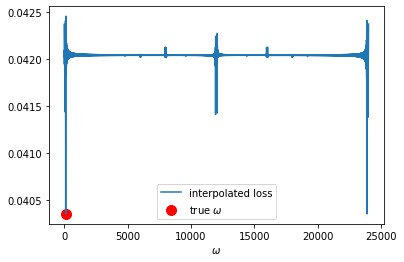

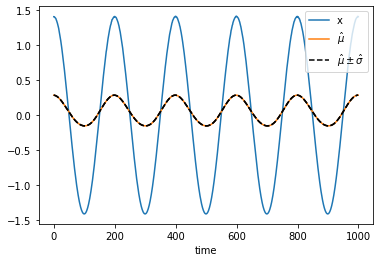

0.029865534062437818
1 tensor(0.0299, dtype=torch.float64)


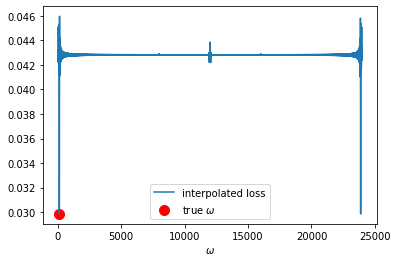

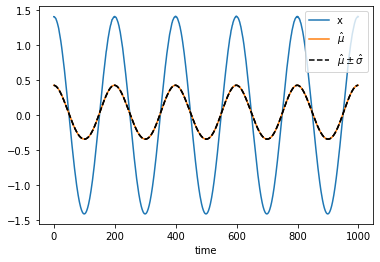

0.02213427101940173
2 tensor(0.0221, dtype=torch.float64)


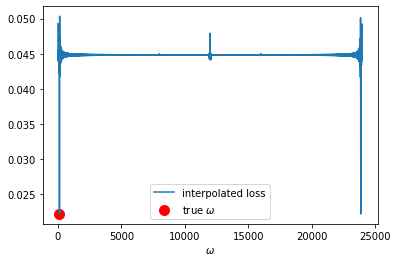

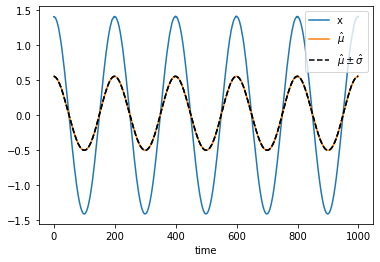

0.016393193528705465
3 tensor(0.0164, dtype=torch.float64)


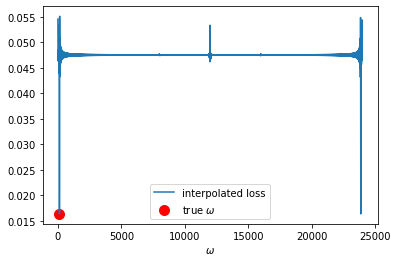

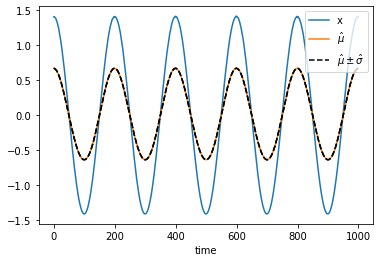

0.012117136522023673
4 tensor(0.0121, dtype=torch.float64)


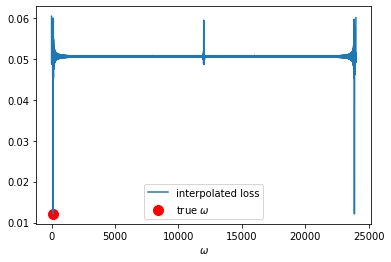

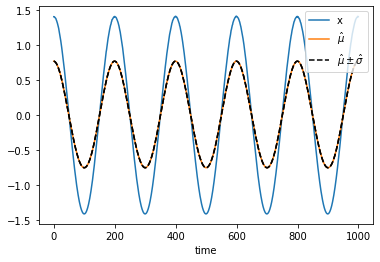

0.008932357969798249
5 tensor(0.0089, dtype=torch.float64)


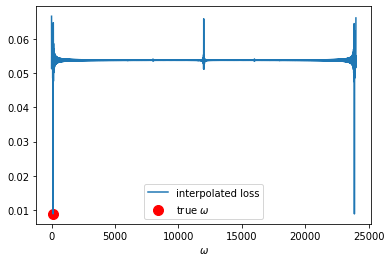

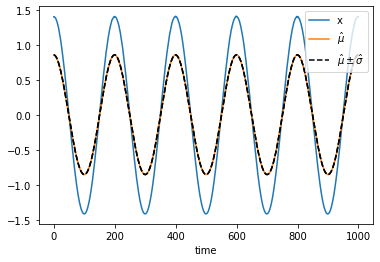

0.006564880936261167
6 tensor(0.0066, dtype=torch.float64)


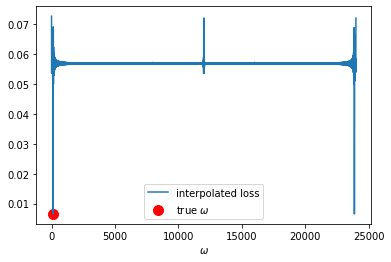

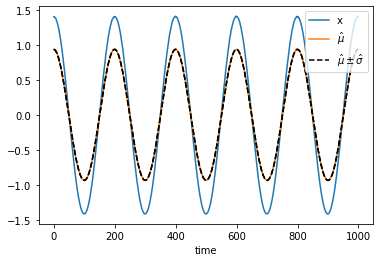

0.004810183890136782
7 tensor(0.0048, dtype=torch.float64)


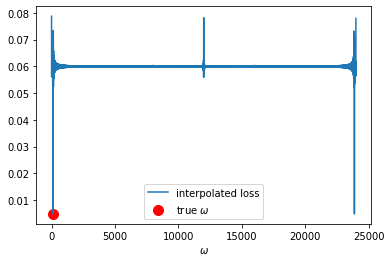

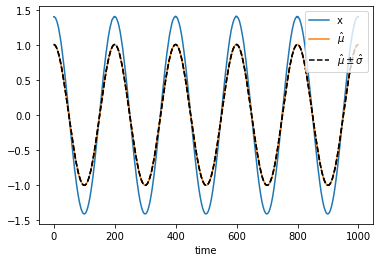

0.0035142085042906748
8 tensor(0.0035, dtype=torch.float64)


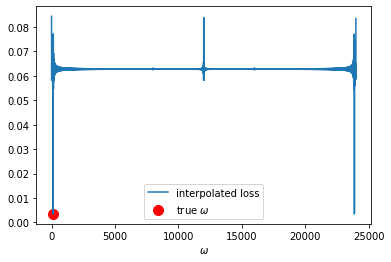

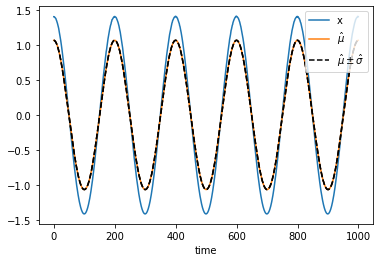

0.002560541508632092
9 tensor(0.0026, dtype=torch.float64)


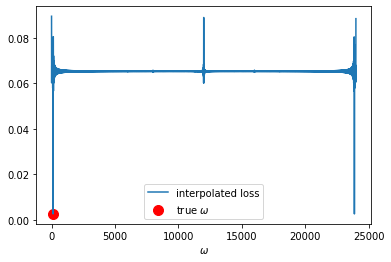

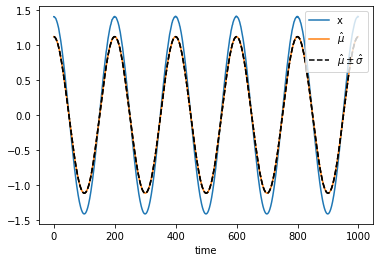

0.001861298687391891
10 tensor(0.0019, dtype=torch.float64)


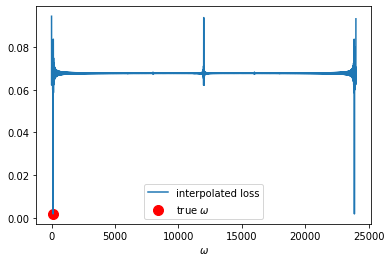

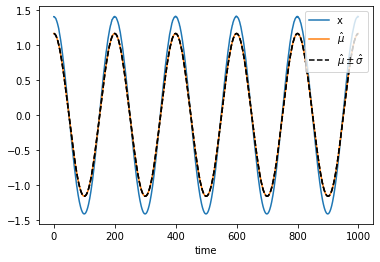

0.0013503484407430663
11 tensor(0.0014, dtype=torch.float64)


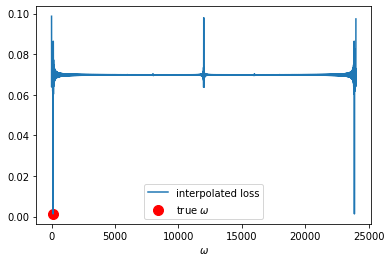

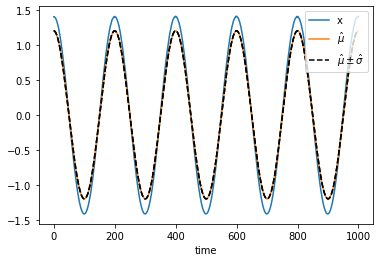

0.0009781549143148339
12 tensor(0.0010, dtype=torch.float64)


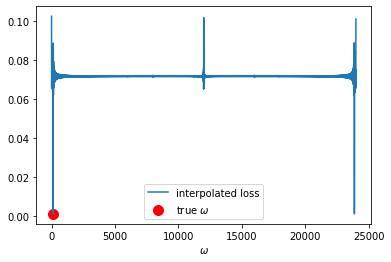

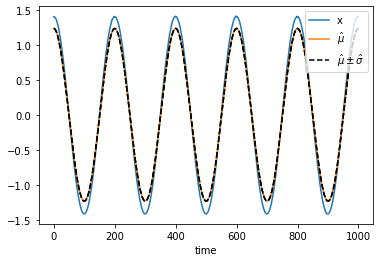

0.0007077992113298622
13 tensor(0.0007, dtype=torch.float64)


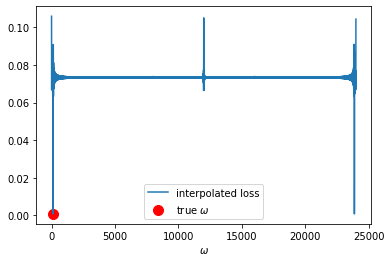

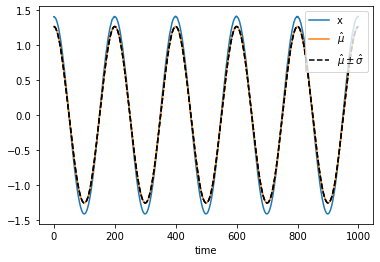

0.0005119047034228496
14 tensor(0.0005, dtype=torch.float64)


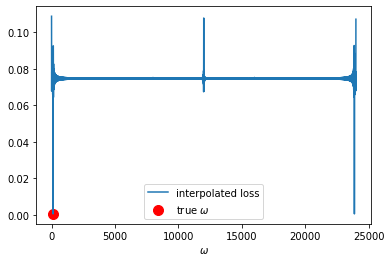

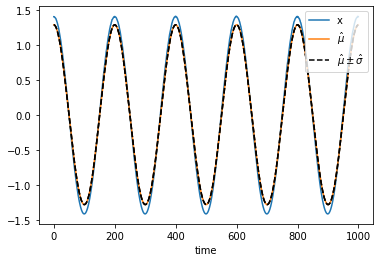

0.00037027000047742373
15 tensor(0.0004, dtype=torch.float64)


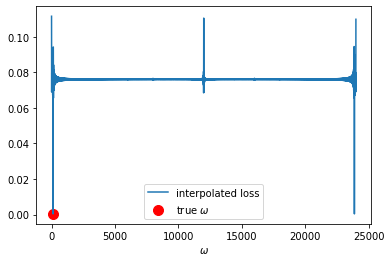

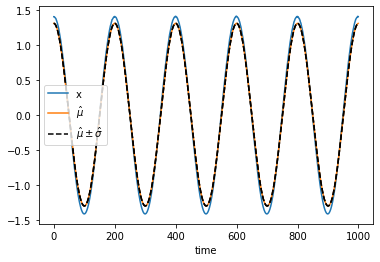

0.00026805626279532497
16 tensor(0.0003, dtype=torch.float64)


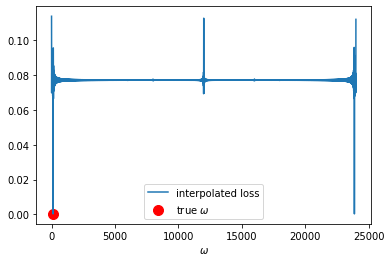

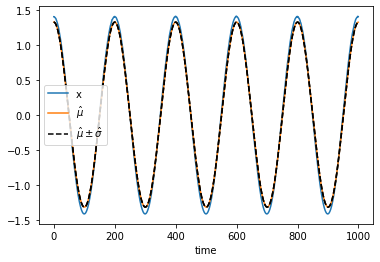

0.0001944091330266203
17 tensor(0.0002, dtype=torch.float64)


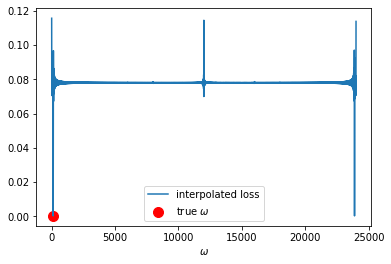

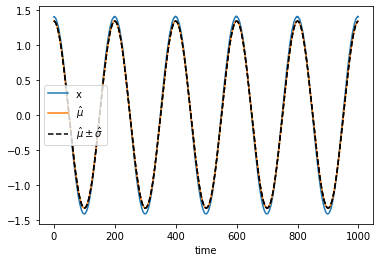

In [115]:
opt = optim.SGD(model_obj.parameters(), lr=1e-1)

train_losses = []
# train the model
for itr in range(18):
    opt.zero_grad()
    
    losses = torch.empty((K, x.shape[0]))

#     inpts = torch.cat([torch.cos(two_pi_block)] * 3 + [torch.sin(two_pi_block)] * 3, -1)  # todo: generalize to more omegas
    inpts = torch.cat([torch.cos(two_pi_block)] + [torch.sin(two_pi_block)], -1)  # todo: generalize to more omegas
    inpts  # [cos_mu_w1, cos_mu_w2, cos_sigma_w1, cos_sigma_w2, cos_alpha_w1, cos_alpha_w2, sin...]
#     y, z, a = model_obj.decode(inpts)
    xhat, = model_obj.decode(inpts)
    for tt in range(x.shape[0]):
#         losses[:, tt] = ((x[tt, :] - y)**2 / (2 * z**2) + z.log() - norm_logcdf(a * (x[tt, :] - y) / z)).squeeze()
        losses[:, tt] = (xhat.squeeze() - x[tt, :]) ** 2 / K
    
    # now each column of losses contains one period of the temporally local loss function
    
    
    # E = stitch together local errors using FFT
    complex_losses = torch.stack([losses.T, zeros_like], -1)
    losses_fft = torch.fft(complex_losses, signal_ndim=1)
    E_ft = torch.zeros((losses.shape[0] * losses.shape[1], 2), dtype=torch.float64)
    for t in range(1, losses.shape[1] + 1):
        E_ft[np.arange(K // 2) * t, :] += losses_fft[t-1, :K//2, :]  # what are the units of "frequency"? 1/idxs of E
    E_ft = torch.cat([E_ft, torch.flip(E_ft * torch.Tensor([[1, -1]]), dims=(0,))])[:-1]
    E = torch.ifft(E_ft, signal_ndim=1)[:, 0]
    omega_idx = int(np.round(omegas[0] * E.shape[0] / (2 * np.pi)))
    E_star = E[omega_idx]
    loss = E_star  # - E.mean()
    print(loss.detach().numpy())

    grad = loss.backward()
    train_losses.append(loss.detach())
    print(itr, train_losses[-1])
    opt.step()
    
    %matplotlib inline
    plt.plot(E.detach(), label="interpolated loss")
    plt.scatter([omega_idx], [E_star.detach()], c="r", s=100, label="true $\omega$")
    plt.xlabel("$\omega$")
    plt.legend()
    plt.show()
    
    plt.plot(x, label="x")
    t = torch.arange(len(x))
#     inpts = torch.stack([torch.cos(omegas[0] * t)] * 3 + [torch.sin(omegas[0] * t)] * 3).T  # todo: generalize to more omegas
    inpts = torch.stack([torch.cos(omegas[0] * t)] + [torch.sin(omegas[0] * t)]).T  # todo: generalize to more omegas
    params = model_obj.output(inpts)
    mean_hat = model_obj.mean(params)
    std_hat = model_obj.std(params)
    plt.plot(mean_hat, label="$\hat \mu$")
    plt.plot(mean_hat + std_hat, "--k", label="$\hat \mu \pm \hat \sigma$")
    plt.plot(mean_hat - std_hat, "--k")
    plt.xlabel("time")
    plt.legend()
    plt.show()

In [81]:
E_ft

tensor([[ 1.6816e+04,  0.0000e+00],
        [-6.8919e-01, -1.6098e+00],
        [-1.4310e+00, -1.0880e+00],
        ...,
        [-4.8391e-01, -1.4226e-02],
        [-1.4310e+00,  1.0880e+00],
        [-6.8919e-01,  1.6098e+00]], dtype=torch.float64,
       grad_fn=<SliceBackward>)

<IPython.core.display.Javascript object>


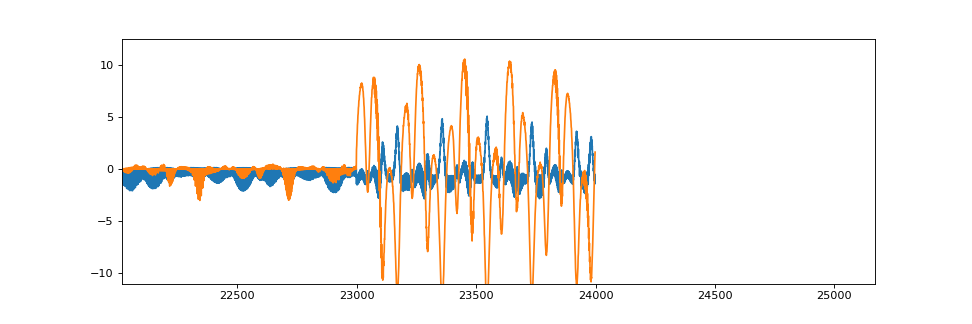

(-12.0, 12.0)

In [84]:
%matplotlib notebook
plt.figure(figsize=(12, 4))
plt.plot(E_ft.detach().numpy())
plt.ylim([-12, 12])

In [87]:
opt.zero_grad()
    
losses = torch.empty((K, x.shape[0]))

In [88]:

inpts = torch.cat([torch.cos(two_pi_block)] * 3 + [torch.sin(two_pi_block)] * 3, -1)  # todo: generalize to more omegas
inpts  # [cos_mu_w1, cos_mu_w2, cos_sigma_w1, cos_sigma_w2, cos_alpha_w1, cos_alpha_w2, sin...]
y, z, a = model_obj.decode(inpts)
#     xhat, = model_obj.decode(inpts)
for tt in range(x.shape[0]):
    losses[:, tt] = ((x[tt, :] - y)**2 / (2 * z**2) + z.log() - norm_logcdf(a * (x[tt, :] - y) / z)).squeeze()
#         losses[:, tt] = (xhat.squeeze() - x[tt, :]) ** 2 / K


In [ ]:
# E = stitch together local errors using FFT
complex_losses = torch.stack([losses.T, zeros_like], -1)
losses_fft = torch.fft(complex_losses, signal_ndim=1)
E_ft = torch.zeros((losses.shape[0] * losses.shape[1], 2), dtype=torch.float64)
for t in range(1, losses.shape[1] + 1):
    E_ft[np.arange(K // 2) * t, :] += losses_fft[t-1, :K//2, :]  # what are the units of "frequency"? 1/idxs of E
E_ft = torch.cat([E_ft, torch.flip(E_ft * torch.Tensor([[1, -1]]), dims=(0,))])[:-1]
E = torch.ifft(E_ft, signal_ndim=1)[:, 0]
omega_idx = int(np.round(omegas[0] * E.shape[0] / (2 * np.pi)))
E_star = E[omega_idx]
loss = E_star  # - E.mean()
print(loss.detach().numpy())

In [107]:
def reconstruct(errors):
    e_fft = np.fft.fft(errors)
    E_ft = np.zeros(errors.shape[0]*K, dtype=np.complex64)

    for t in range(1,e_fft.shape[0]+1):
        E_ft[np.arange(K//2)*t] += e_fft[t-1,:K//2]

    E_ft = np.concatenate([E_ft, np.conj(np.flip(E_ft))])[:-1]
    E = np.real(np.fft.ifft(E_ft))
    return E, E_ft

In [102]:
losses.shape

torch.Size([12, 1000])

In [226]:
errors = losses.T.detach()
e_fft = np.fft.fft(errors)
EE_ft = np.zeros(errors.shape[0]*K, dtype=np.complex64)

for t in range(1,e_fft.shape[0]+1):
    EE_ft[np.arange(K//2)*t] += e_fft[t-1,:K//2]

EE_ft = np.concatenate([EE_ft, np.conj(np.flip(EE_ft))])[:-1]
EE = np.real(np.fft.ifft(EE_ft))

In [227]:
e_fft.shape, losses_fft.shape

((1000, 12), torch.Size([1000, 12, 2]))

In [229]:
EE_ft.shape, E_ft.shape

((23999,), torch.Size([24000, 2]))

In [222]:
EE, E

(array([0.60256482, 0.60867274, 0.62126004, ..., 0.63344935, 0.61528097,
        0.60463549]),
 tensor([2.5965, 2.6339, 2.7014,  ..., 2.7989, 2.7048, 2.6220],
        dtype=torch.float64, grad_fn=<SelectBackward>))

<IPython.core.display.Javascript object>


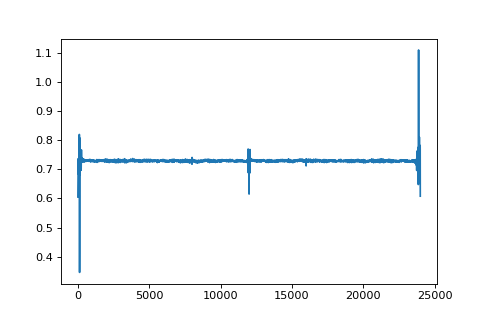

In [217]:
%matplotlib notebook
plt.plot(E)

In [40]:
yy

tensor([0.3698], grad_fn=<AddBackward0>)

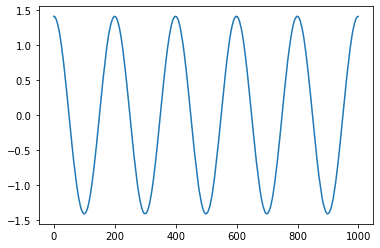

In [27]:
plt.plot(x)

In [14]:
model_obj

SkewNormalNLL(
  (l1_mu): Linear(in_features=2, out_features=32, bias=True)
  (l2_mu): Linear(in_features=32, out_features=64, bias=True)
  (l3_mu): Linear(in_features=64, out_features=1, bias=True)
  (l1_sig): Linear(in_features=2, out_features=32, bias=True)
  (l2_sig): Linear(in_features=32, out_features=64, bias=True)
  (l3_sig): Linear(in_features=64, out_features=1, bias=True)
  (l1_a): Linear(in_features=2, out_features=32, bias=True)
  (l2_a): Linear(in_features=32, out_features=64, bias=True)
  (l3_a): Linear(in_features=64, out_features=1, bias=True)
)

In [25]:
arr.shape

(1, 100, 2)

In [43]:
t = np.linspace(0, 2 * np.pi, 100)
arr = np.stack([np.cos(t) * 0] * 3 + [np.sin(t)] * 3).T
inpts = torch.Tensor(arr)
y, z, a = model_obj.decode(inpts)

<IPython.core.display.Javascript object>


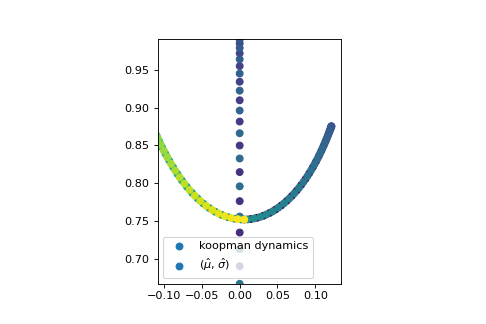

In [46]:
%matplotlib notebook
plt.scatter(arr[:, 0], arr[:, 3], c=t, label="koopman dynamics")
plt.scatter(y.detach(), z.detach(), c=t, label="($\hat \mu$, $\hat \sigma$)")
# plt.plot(arr, z.detach(), label="z")
# plt.plot(arr, a.detach(), label="a")
plt.legend()
plt.gca().set_aspect(1)

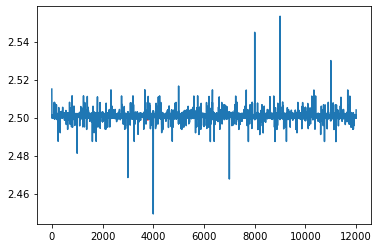

In [39]:
%matplotlib notebook
plt.plot(E.detach())
plt.scatter([omega_idx], [E_star.detach()], c="r", s=50)

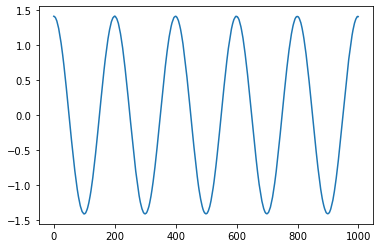

In [52]:
plt.plot(x)

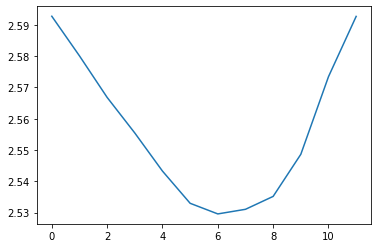

In [167]:
plt.plot(losses[:, 0].detach())  # when t=0 the loss should not depend on w, because wt = 0 for all w

In [ ]:
# plot
plt.plot(x_hat, "tab:orange", label="$\hat x$")
plt.plot(data, "tab:blue", label="$x$")
plt.plot(x_hat + std_hat, "--k", label="$\hat x \pm \hat \sigma$")
plt.plot(x_hat - std_hat, "--k")
plt.xlim([9_900, 10_100])
plt.legend()
plt.show()

plt.plot(mu_t, label="$\mu$")
plt.plot(x_hat, ":k", label="$\hat \mu$")
plt.plot(sigma_t, label="$\sigma$")
plt.plot(std_hat, "--k", label="$\hat \sigma$")
plt.xlim([50_900, 51_100])
plt.legend()
plt.show()

TypeError: linspace() got an unexpected keyword argument 'endpoint'

In [20]:
import torch

In [21]:
ttt = torch.tensor([1])

In [22]:
ttt.type?

In [95]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@authors: Alex Mallen (atmallen@uw.edu)
Built on code from Henning Lange (helange@uw.edu)
"""

import torch

from torch import nn
from torch import optim

import numpy as np

class KoopmanProb(nn.Module):
    r'''
    model_obj: an object that specifies the function f and how to optimize
               it. The object needs to implement numerous function. See
               below for some examples.
    sample_num: number of samples from temporally local loss used to
                reconstruct the global error surface.
    batch_size: Number of temporal snapshots processed by SGD at a time
                default = 32
                type: int
    parallel_batch_size: Number of temporaly local losses sampled in parallel.
                         This number should be as high as possible but low enough
                         to not cause memory issues.
                         default = 1000
                         type: int
    device: The device on which the computations are carried out.
            Example: cpu, cuda:0, or list of GPUs for multi-GPU usage, i.e. ['cuda:0', 'cuda:1']
            default = 'cpu'
    seed: The seed to set for pyTorch and numpy--WARNING: does not seem to make results reproducible
    loss_weights: torch.tensor of shape (xt.shape[0],) that represents how to weight the losses over time.
                  default=None
    '''

    def __init__(self, model_obj, sample_num=12, seed=None, **kwargs):

        super(KoopmanProb, self).__init__()
        self.total_freqs = model_obj.total_freqs
        self.num_freqs = model_obj.num_freqs

        if seed is not None:
            torch.set_deterministic(True)
            torch.manual_seed(seed)
            np.random.seed(seed)

        if 'device' in kwargs:
            self.device = kwargs['device']
            if type(kwargs['device']) == list:
                self.device = kwargs['device'][0]
                multi_gpu = True
            else:
                multi_gpu = False
        else:
            self.device = 'cpu'
            multi_gpu = False

        self.multi_gpu = multi_gpu

        self.parallel_batch_size = kwargs['parallel_batch_size'] if 'parallel_batch_size' in kwargs else 1000
        self.batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 32
        self.loss_weights = kwargs['loss_weights'] if 'loss_weights' in kwargs else None

        self.max_t = 1
        # Initial guesses for frequencies
        self.omegas = torch.linspace(0.01, 0.5, self.total_freqs, device=self.device)

        model_obj = model_obj.to(self.device)
        self.model_obj = nn.DataParallel(model_obj, device_ids=kwargs['device']) if multi_gpu else model_obj
        self.sample_num = sample_num
        self.num_fixed_omegas = 0

    def find_fourier_omegas(self, xt, num_fourier_modes, tt=None):
        """
        computes the argmax of the fft of xt to find frequencies the data exhibits. The first
        num_fourier_modes values of self.omega will be fixed to these values throughout optimization
        (although they will still be tuned through SGD if lr_omega != 0 when you call fit)
        :param xt: the data to initialize fourier modes with. Data samples must be equally spaced
        :param num_fourier_modes: the number of fourier frequencies to find
        :return: omegas found
        """
        if tt is not None:
            raise ValueError("Fourier frequencies of non uniform samples is not yet implemented")

        self.num_fixed_omegas = max(self.num_fixed_omegas, num_fourier_modes)
        best_omegas = None
        if num_fourier_modes > 0:
            xt_ft = np.fft.fft(xt, axis=0)
            adj_xt_ft = (abs(xt_ft) + abs(np.flip(xt_ft))).reshape(xt_ft.size)
            freqs = np.tile(np.fft.fftfreq(len(xt_ft)), xt.shape[1])

            best_omegas = np.zeros(num_fourier_modes)
            i = 0
            num_found = 0
            while num_found < num_fourier_modes:
                amax = np.argpartition(-adj_xt_ft[:len(xt_ft) // 2], i)[i]  # ith biggest freq
                if freqs[amax] != 0 and all(abs(1 - best_omegas / freqs[amax]) > 0.1):
                    best_omegas[num_found] = freqs[amax]
                    num_found += 1
                i += 1

            best_omegas = 2 * np.pi * torch.tensor(best_omegas)

        if best_omegas is not None:
            idx = 0
            for num_freqs in self.num_freqs:
                self.omegas[idx:idx + num_fourier_modes] = best_omegas
                idx += num_freqs
        return best_omegas

    def init_periods(self, periods):
        """
        sets the first len(periods) frequencies for each parameter equal to 2 pi / periods,
        which will remain constant through optimization (although they will still be tuned through SGD
        if lr_omega != 0 when you call fit)
        :param periods: the periods you think the data exhibits
        """
        if len(periods) > min(self.num_freqs):
            raise ValueError("Too many periods provided. Must be at most min(self.num_freqs).")

        self.num_fixed_omegas = max(self.num_fixed_omegas, len(periods))  # increase it if necessary
        hard_coded_omegas = 2 * np.pi / torch.tensor(periods, dtype=float)
        idx = 0
        for num_freq in self.num_freqs:
            self.omegas[idx:idx + len(periods)] = hard_coded_omegas
            idx += num_freq

    def sample_error(self, xt, which, tt=None):
        '''
        sample_error computes all temporally local losses within the first
        period, i.e. between [0,2pi/t]
        Parameters
        ----------
        xt : TYPE numpy.array
            Temporal data whose first dimension is time.
        which : TYPE int
            Index of the entry of omega
        Returns
        -------
        TYPE numpy.array
            Matrix that contains temporally local losses between [0,2pi/t]
            dimensions: [T, sample_num]
        '''
        if type(xt) == np.ndarray:
            xt = torch.tensor(xt, device=self.device)

        num_samples = self.sample_num
        omega = self.omegas
        batch = self.parallel_batch_size

        t = torch.arange(xt.shape[0], device=self.device) + 1
        errors = []

        pi_block = torch.zeros((num_samples, len(omega)), device=self.device)
        pi_block[:, which] = torch.arange(0, num_samples) * np.pi * 2 / num_samples

        if t.shape[0] < batch:
            batch = t.shape[0]
        for i in range(int(np.ceil(xt.shape[0] / batch))):
            t_batch = t[i * batch:(i + 1) * batch][:, None]
            wt = t_batch * omega[None]
            wt[:, which] = 0
            wt = wt[:, None] + pi_block[None]
            k = torch.cat([torch.cos(wt), torch.sin(wt)], -1)  # TODO I THINK THIS MIGHT BE WRONG BECAUSE OF INDEXING # [cos_mu_w1, cos_mu_w2, cos_sigma_w1, cos_sigma_w2, cos_alpha_w1, cos_alpha_w2, sin...]
            loss = self.model_obj(k, xt[i * batch:(i + 1) * batch, None], None).cpu().detach().numpy()
            errors.append(loss)

        if self.device.startswith('cuda'):
            torch.cuda.empty_cache()

        return np.concatenate(errors, axis=0)

    def reconstruct(self, errors, use_heuristic=True):
        """
        reconstructs the total error surface from samples of temporally local loss functions
        :param errors: the temporally local loss functions for t=1,2... sampled within 2pi/t
        :param use_heuristic: whether to implement the unknown phase problem heuristic to improve optimization
        :return: Global loss function (the first period--from 0 to 2pi) with respect to omega, its fft
        """

        e_fft = np.fft.fft(errors)
        E_ft = np.zeros(errors.shape[0] * self.sample_num, dtype=np.complex64)

        for t in range(1, e_fft.shape[0] + 1):
            E_ft[np.arange(self.sample_num // 2) * t] += e_fft[t - 1, :self.sample_num // 2]

        E_ft = np.concatenate([E_ft, np.conj(np.flip(E_ft))])[:-1]
        E = np.real(np.fft.ifft(E_ft))

        if use_heuristic:
            E = -np.abs(E - np.median(E))
            # E = gaussian_filter(E, 5)

        return E, E_ft

    def fft(self, xt, i, tt=None, verbose=False):
        '''
        fft first samples all temporaly local losses within the first period
        and then reconstructs the global error surface w.r.t. omega_i
        Parameters
        ----------
        xt : TYPE numpy.array
            Temporal data whose first dimension is time.
        i : TYPE int
            Index of the entry of omega
        verbose : TYPE boolean, optional
            DESCRIPTION. The default is False.
        tt : TYPE numpy.array
            the times of measurement of xt
        Returns
        -------
        E : TYPE numpy.array
            Global loss surface in time domain.
        E_ft : TYPE
            Global loss surface in frequency domain.
        '''
        assert (tt is None), "Not yet implemented for non-uniform samples"  # TODO


        E, E_ft = self.reconstruct(self.sample_error(xt, i))
        omegas = np.linspace(0, 0.5, len(E))

        # get the values of omega that have already been used
        omegas_current = self.omegas.cpu().detach().numpy()
        omegas_current[i] = -1
        for j, num_freqs in enumerate(self.num_freqs):
            lower = sum(self.num_freqs[:j])
            upper = sum(self.num_freqs[:j + 1])
            if lower <= i < upper:
                omegas_current = omegas_current[lower:upper]

        found = False
        j = 0
        while not found:

            amax = np.argpartition(E, j)[j]  # jth biggest freq
            # The if statement avoids non-unique entries in omega and that the
            # frequencies are 0 (should be handled by bias term)
            # "nonzero AND has a period that's more than 1 different from those that have already been discovered"
            if amax >= 1 and np.all(np.abs(2 * np.pi / omegas_current - 1 / omegas[amax]) > 1):
                found = True
                if verbose:
                    print('Setting', i, 'to', 1 / omegas[amax])

                self.omegas[i] = torch.from_numpy(np.array([omegas[amax]]))
                self.omegas[i] *= 2 * np.pi

            j += 1

        # plt.plot(omegas, E)
        # plt.title(f"omega {i}")
        # plt.xlabel("frequency (periods per time)")
        # plt.ylabel("loss")
        # plt.show()

        return E, E_ft

    def sgd(self, xt, tt=None, weight_decay=0, verbose=False, lr_theta=1e-5, lr_omega=1e-5, training_mask=None):
        '''
        sgd performs a single epoch of stochastic gradient descent on parameters
        of f (Theta) and frequencies omega
        Parameters
        ----------
        xt : TYPE numpy.array
            Temporal data whose first dimension is time.
        tt : TYPE numpy.array
            the times of measurement of xt
        verbose : TYPE boolean, optionally
            The default is False.
        Returns
        -------
        TYPE float
            Loss.
        '''

        batch_size = self.batch_size

        T = xt.shape[0]

        omega = nn.Parameter(self.omegas)

        # opt = optim.Adam(self.model_obj.parameters(), lr=1e-4 * (1 / (1 + np.exp(-(iteration - 15)))), betas=(0.99, 0.9999), eps=1e-5, weight_decay=weight_decay)
        # opt = optim.SGD(self.model_obj.parameters(), lr=lr_theta * (1 / (1 + np.exp(-(iteration - 15)))), weight_decay=weight_decay)
        opt = optim.SGD(self.model_obj.parameters(), lr=lr_theta, weight_decay=weight_decay)
        opt_omega = optim.SGD([omega], lr=lr_omega / T)
        
        # TODO make sure starting with t=1 works
        t = torch.arange(T, device=self.device) if tt is None else torch.tensor(tt, device=self.device)

        losses = []

        # create random batches
        idxs = np.arange(T)
        np.random.shuffle(idxs)
        batches = idxs[:T // batch_size * batch_size].reshape((T // batch_size, batch_size))

        for i in range(len(batches)):

            opt.zero_grad()
            opt_omega.zero_grad()

            ts = t[batches[i]]

            o = torch.unsqueeze(omega, 0)
            ts_ = torch.unsqueeze(ts, -1).type(torch.get_default_dtype()) + 1

            xt_t = torch.tensor(xt[batches[i], :], device=self.device)

            wt = ts_ * o

            k = torch.cat([torch.cos(wt), torch.sin(wt), ts_ / self.max_t], -1)
            batch_mask = training_mask[batches[i]] if training_mask is not None else None

            batch_losses = self.model_obj(k, xt_t, batch_mask)
            if self.loss_weights is not None:
                weighted_losses = batch_losses * self.loss_weights[batches[i]]
                loss = torch.mean(weighted_losses)
            else:
                loss = torch.mean(batch_losses)

            loss.backward()

            opt.step()
            opt_omega.step()

            losses.append(loss.cpu().detach().numpy())

        if verbose:
            print('Setting periods to', 2 * np.pi / omega)

        self.omegas = omega.data

        return np.mean(losses)

    def fit(self, xt, tt=None, iterations=20, interval=10, cutoff=50, weight_decay=1e-3, verbose=False, lr_theta=1e-4,
            lr_omega=1e-5, training_mask=None):
        '''
        Given a dataset, this function alternatingly optimizes omega and
        parameters of f. Specifically, the algorithm performs interval many
        epochs, then updates all entries in omega. This process is repeated
        until iterations-many epochs have been performed
        Parameters
        ----------
        xt : TYPE 2D numpy.array
            Temporal data whose first dimension is time.
        tt : TYPE 1D numpy.array of shape (xt.shape[0],)
            the times of measurement of xt. Default None, which assumes tt is uniform
        iterations : TYPE int, optional
            Total number of SGD epochs. The default is 10.
        interval : TYPE, optional
            The interval at which omegas are updated, i.e. if
            interval is 5, then omegas are updated every 5 epochs. The default is 5.
        verbose : TYPE boolean, optional
            DESCRIPTION. The default is False.
        cutoff : TYPE int, number of iterations after which to stop updating omegas
        weight_decay : TYPE float, regularization parameter
        lr_theta : TYPE float, learning rate for the model object
        lr_omega : TYPE float, learning rate for adjusting omegas
        training_mask : TYPE torch.tensor or np.array, which training data points should be
                        using in optimizing the location parameter (eg. mu).
                        shape should match xt. a 1 indicates to train mu on that data,
                        a 0 indicates not to.
                        Default: None (equivalent to torch.ones(xt.shape))
        Returns
        -------
        Losses
        '''

        assert (len(xt.shape) > 1), 'Input data needs to be at least 2D'
        if training_mask is not None:
            training_mask = torch.Tensor(training_mask)

        self.max_t = tt.max() if tt is not None else xt.shape[0]
        l = None
        losses = []
        for i in range(iterations):

            if i % interval == 0 and i < cutoff:
                # only update omegas that are note the first self.num_fixed_omegas idxs of each param
                param_num = 0
                for num_freqs in self.num_freqs:
                    for k in range(param_num + self.num_fixed_omegas, param_num + num_freqs):
                        self.fft(xt, k, tt=tt, verbose=verbose)
                    param_num += num_freqs

            if verbose:
                print('Iteration ', i)
                print(2 * np.pi / self.omegas)

            l = self.sgd(xt, tt=tt, weight_decay=weight_decay, verbose=verbose, lr_theta=lr_theta, lr_omega=lr_omega,
                         training_mask=training_mask)
            losses.append(l)
            if verbose:
                print('Loss: ', l)
            elif i % 50 == 10:
                print(f"Loss at iteration {i}: {l}")

            if not np.isfinite(l):
                break

        print("Final loss:", l)
        return losses

    def predict(self, T):
        '''
        Predicts the data from 1 to T.
        Parameters
        ----------
        T : TYPE int
            Prediction horizon. Equivalent to np.arange(T)
            TYPE numpy.ndarray
            Exact times for which to predict, 1D array
        Returns
        -------
        TYPE numpy.array
            xhat at the specified times.
        '''

        t = torch.arange(T, device=self.device) + 1 if isinstance(T, int) else torch.tensor(T, device=self.device)
        ts_ = torch.unsqueeze(t, -1).type(torch.get_default_dtype())

        o = torch.unsqueeze(self.omegas, 0)
        k = torch.cat([torch.cos(ts_ * o), torch.sin(ts_ * o), ts_ / self.max_t], -1)

        if self.multi_gpu:
            params = self.model_obj.module.decode(k)
        else:
            params = self.model_obj.decode(k)

        return tuple(param.cpu().detach().numpy() for param in params)
